In [1]:
import os
import sys
import scipy
import numpy as np
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy import stats
from matplotlib import pyplot as plt, rcParams, rc
from sklearn import decomposition

%matplotlib inline
%precision 4
%config InlineBackend.figure_format = 'retina'

rc('animation', html='html5')
rcParams['figure.figsize'] = 8, 10
np.set_printoptions(precision=4, linewidth=100)

In [2]:
# load the videos
video = mpy.VideoFileClip('download.mp4')

In [3]:
video.ipython_display(width=300)

100%|█████████▉| 350/351 [00:01<00:00, 327.36it/s]


In [4]:
video.duration, video.size, video.fps

(50.0000, [320, 240], 7.0000)

In [5]:
def create_data_matrix_from_video(clip, k, scale):
    frames = []
    for i in range(k * int(clip.duration)):
        frame = clip.get_frame(i / float(k))
        frame = rgb2grey(frame).astype(int)
        frame = scipy.misc.imresize(frame, scale).flatten()
        frames.append(frame)
    return np.vstack(frames).T # stack images horizontally

def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def plot_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f


In [6]:
# change resolution of image
scale =25    # scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))
dims # single frame dimensions (height x width)

(60, 80)

In [7]:
fps = 100
M = create_data_matrix_from_video(video, fps, scale)
np.save('video_matrix', M)
M.shape, dims

((4800, 5000), (60, 80))

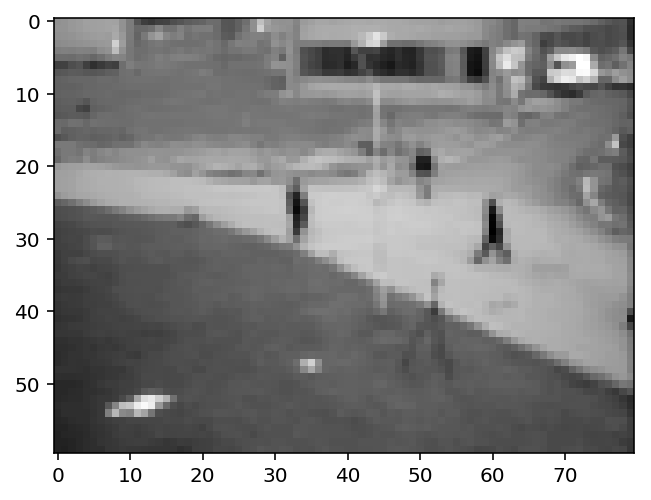

In [8]:
test_image = M[:,140].reshape(dims)
plt.imshow(test_image, cmap='gray')

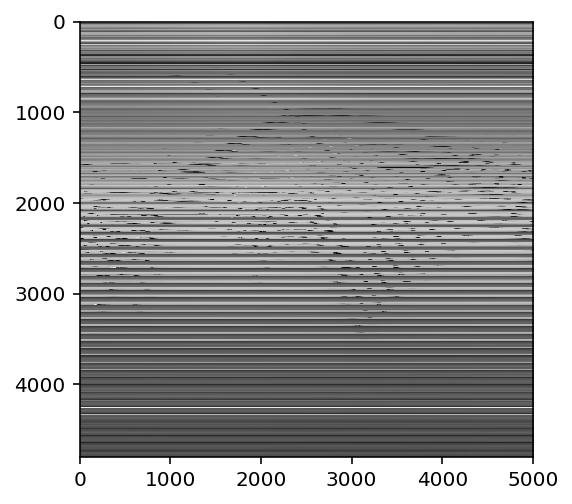

In [9]:
plt.imshow(M, cmap='gray')

In [10]:
random_columns = np.random.randint(0, M.shape[1], 1000)
background = stats.mode(M[:, random_columns], axis=1).mode
np.save('background', background)
background.shape

(4800, 1)

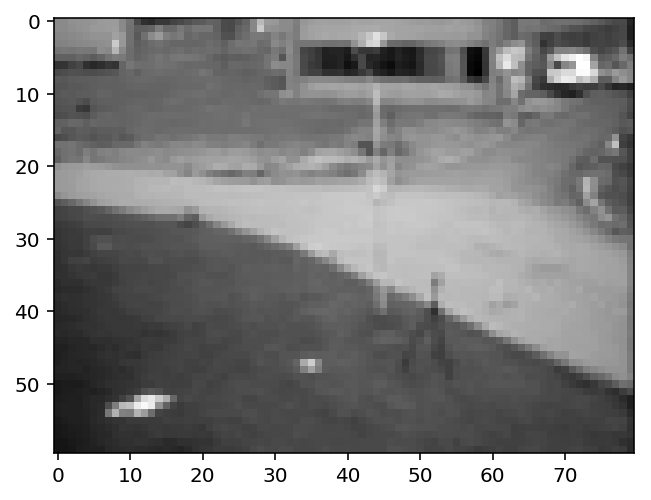

In [11]:
plt.imshow(background.reshape(dims), cmap='gray')

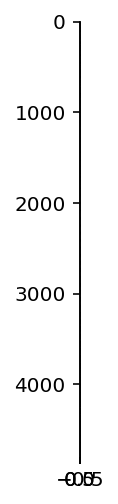

In [12]:
plt.imshow(background, cmap='gray')

In [55]:
people = M - background
people.shape


(4800, 5000)

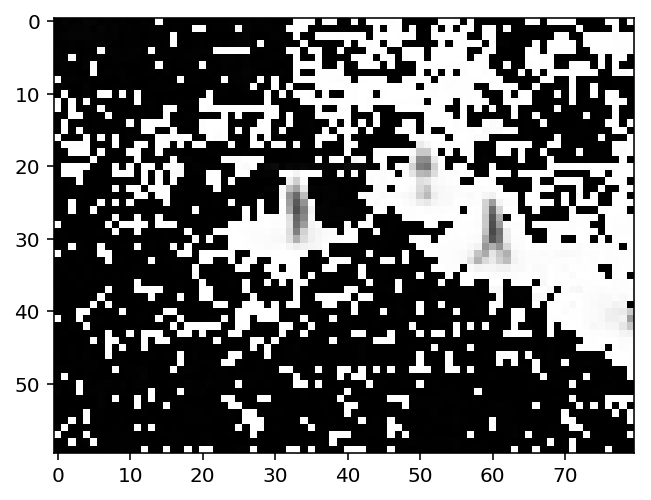

In [13]:
plt.imshow(people[:,140].reshape(dims), cmap='gray')


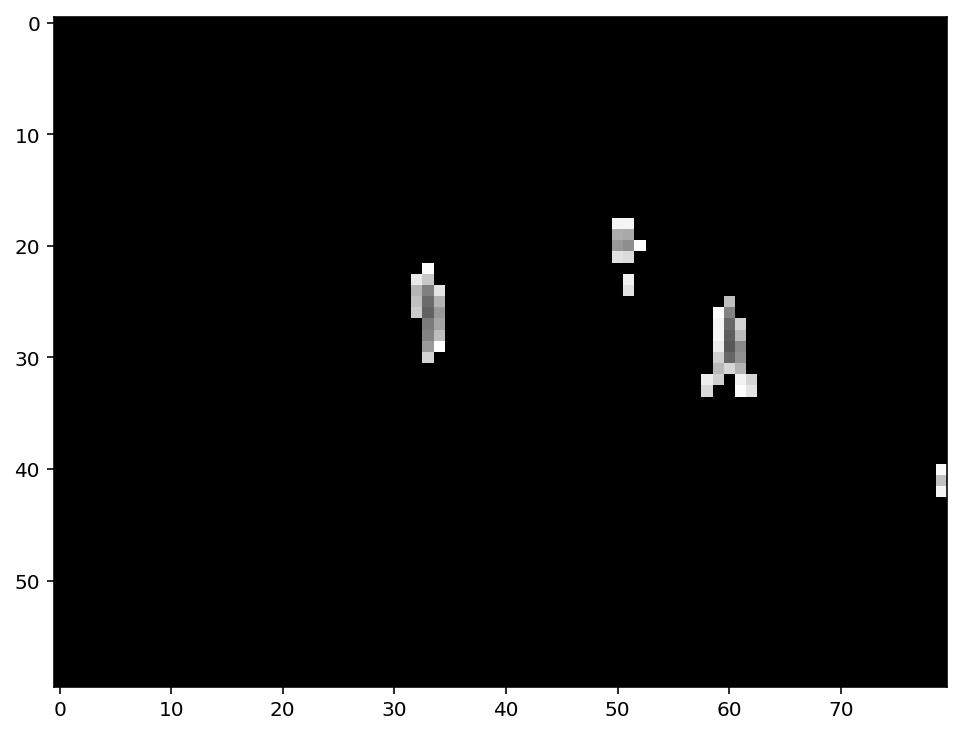

In [56]:
people[(people < 25) | (people > 210)] = 0
plt.imshow(people[:,140].reshape(dims), cmap='gray')

In [57]:
#apply svd
U, s, Vh = decomposition.randomized_svd(M, 5)
U.shape, s.shape, Vh.shape
np.savez('svd_components', U, s, Vh)

In [58]:
low_rank_M = U @ np.diag(s) @ Vh
np.save('low_rank_video_matrix', low_rank_M)
low_rank_M.shape

(4800, 5000)

In [59]:
people = M - low_rank_M
people.shape

(4800, 5000)

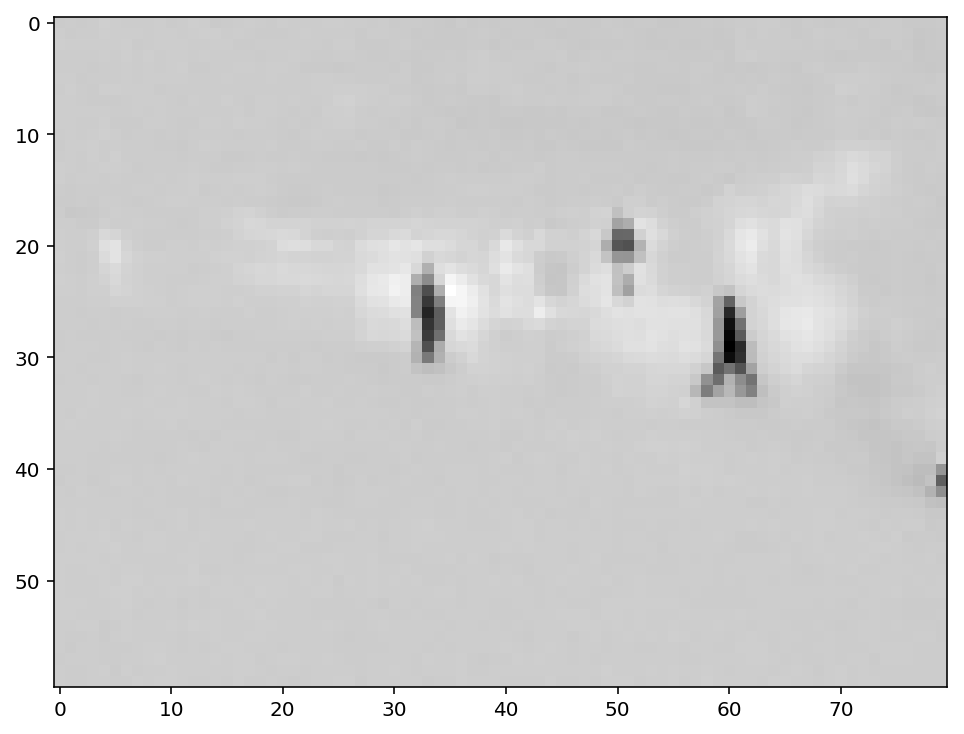

In [60]:
plt.imshow(people[:,140].reshape(dims), cmap='gray')

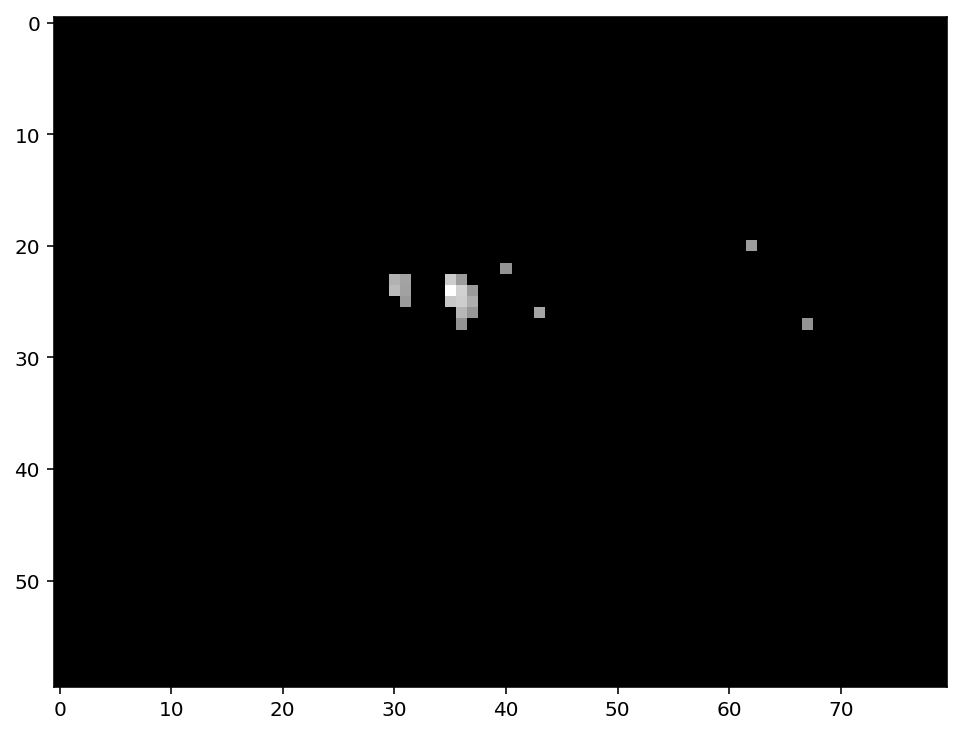

In [61]:
people[(people < 25) | (people > 210)] = 0
plt.imshow(people[:,140].reshape(dims), cmap='gray')

[MoviePy] >>>> Building video people.mp4
[MoviePy] Writing video people.mp4


100%|█████████▉| 4900/4901 [06:24<00:00, 12.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: people.mp4 



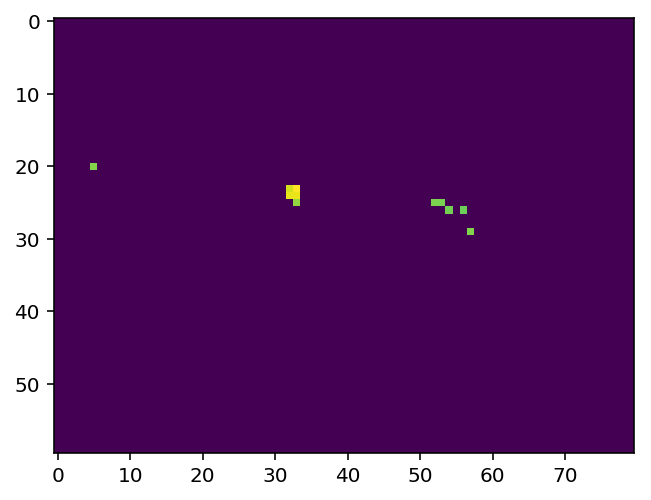

In [20]:
people_frames = people.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('people.mp4', fps=fps)

In [21]:
AA = mpy.VideoFileClip('people.mp4')
AA.ipython_display(width=300)

100%|█████████▉| 4900/4901 [00:07<00:00, 617.28it/s]


In [22]:
AA.fps

100.0000

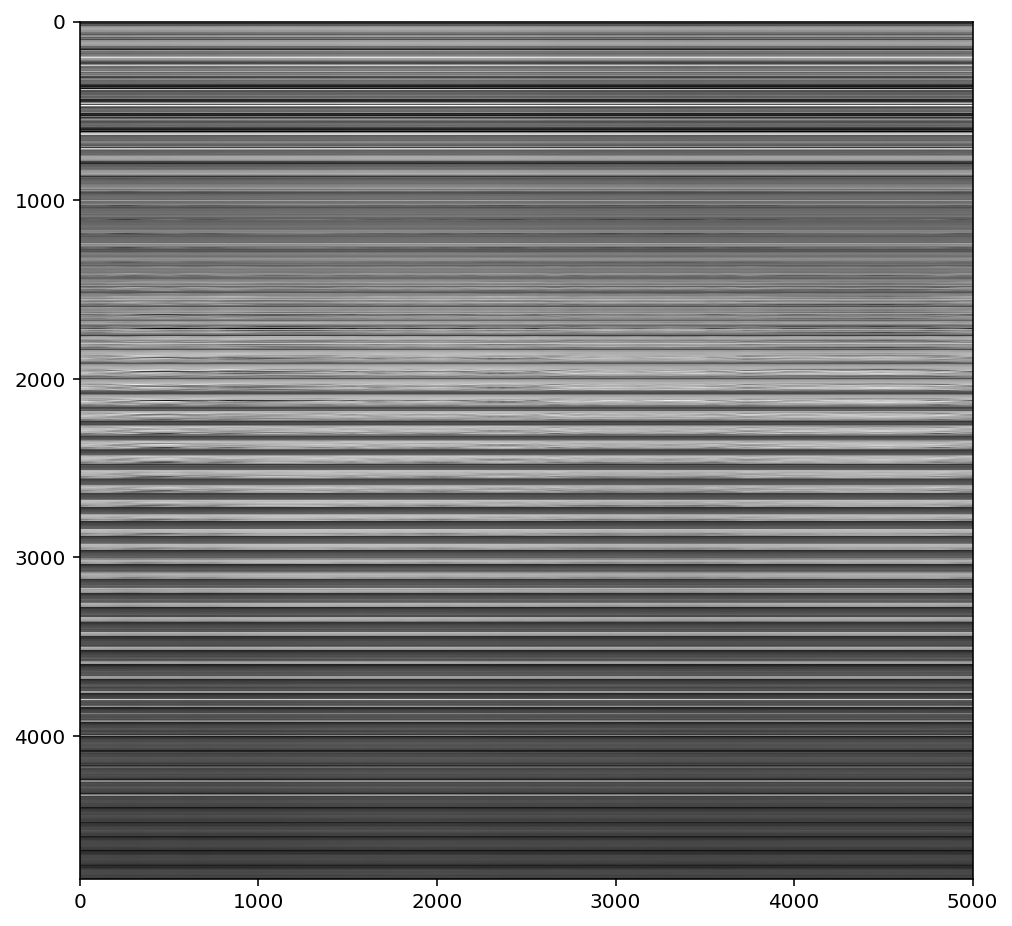

In [62]:
plt.imshow(low_rank_M, cmap='gray')

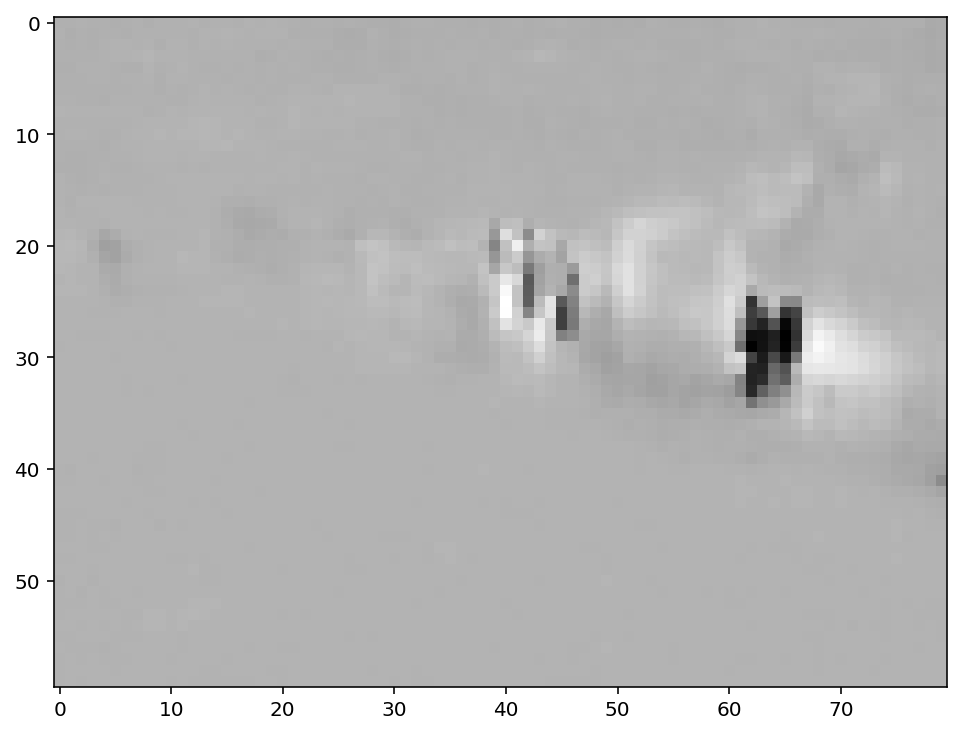

In [63]:
plt.imshow(np.reshape(M[:,550] - low_rank_M[:,550], dims), cmap='gray')

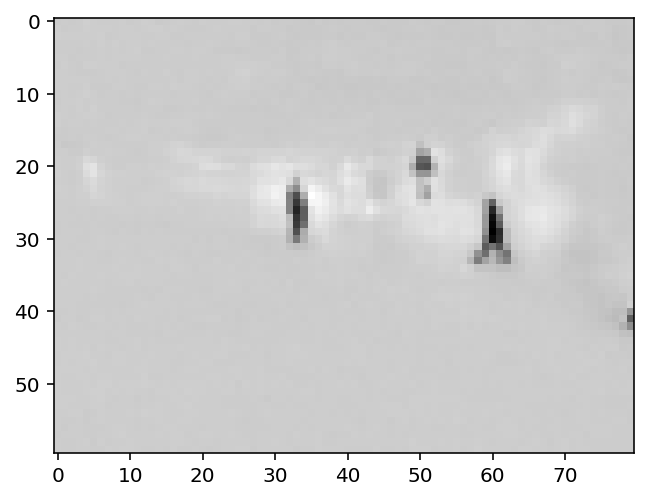

In [25]:
plt.imshow(np.reshape(M[:,140] - low_rank_M[:,140], dims), cmap='gray')

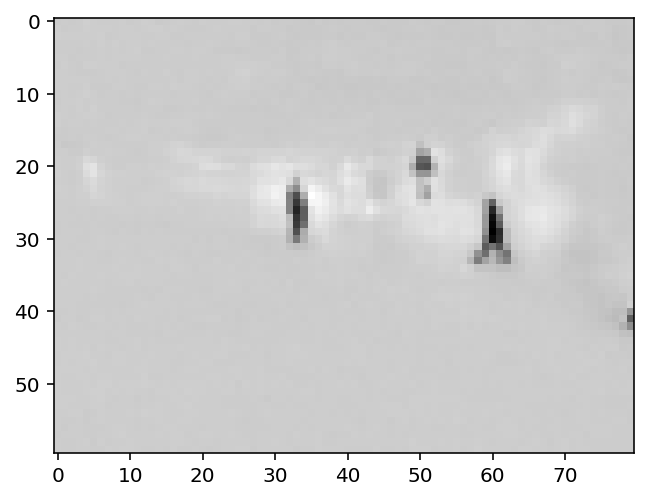

In [26]:
plt.imshow(np.reshape(M[:,140] - low_rank_M[:,140], dims), cmap='gray')

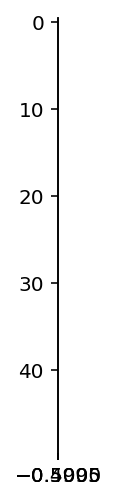

In [27]:
# Zoom the image
plt.imshow(np.reshape(M[:,140] - low_rank_M[:,140], dims)[10:150,100:250], cmap='gray')

In [28]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [29]:
TOL=1e-9

In [30]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [31]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [32]:
def _svd(M, rank):
    return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [33]:
def norm_op(M):
    return _svd(M, 1)[1][0]

In [34]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [35]:
m, n = M.shape
round(m * .05)

240

In [36]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [37]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.12691464708363334
rank sv: 241
error:  0.03852332996184365
rank sv: 41
error:  0.004882084384617361
rank sv: 281
error:  0.0004071323656426907
rank sv: 274
error:  2.079064619588213e-05


In [38]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

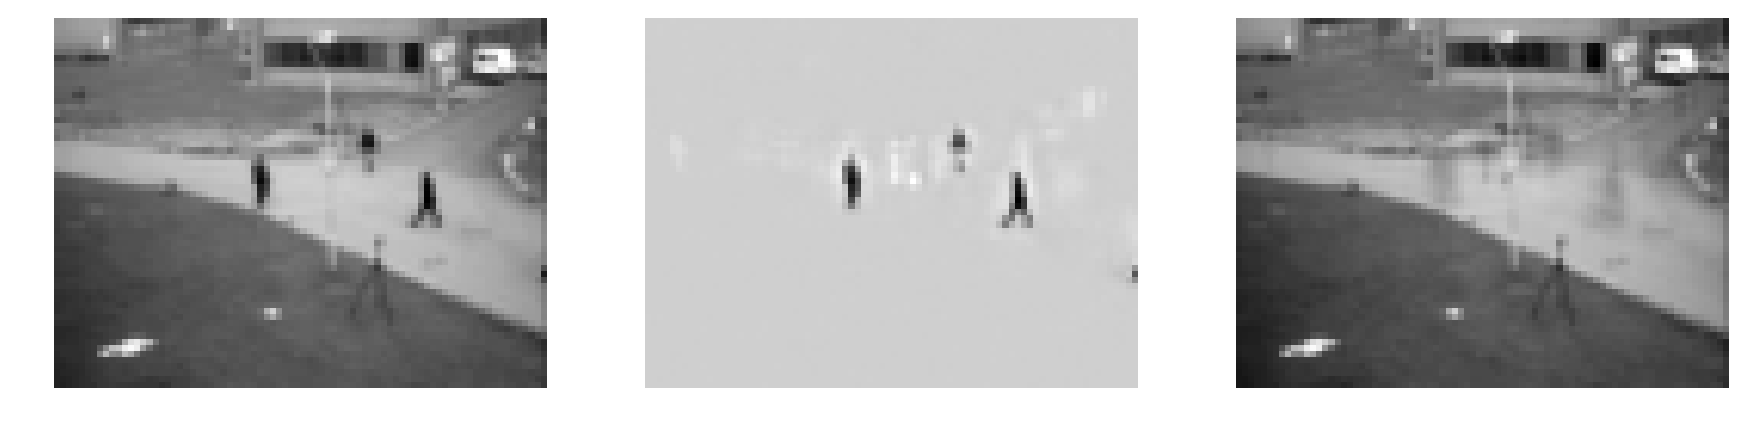

In [39]:
f = plt_images(M, S, L, [140], dims)

In [40]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

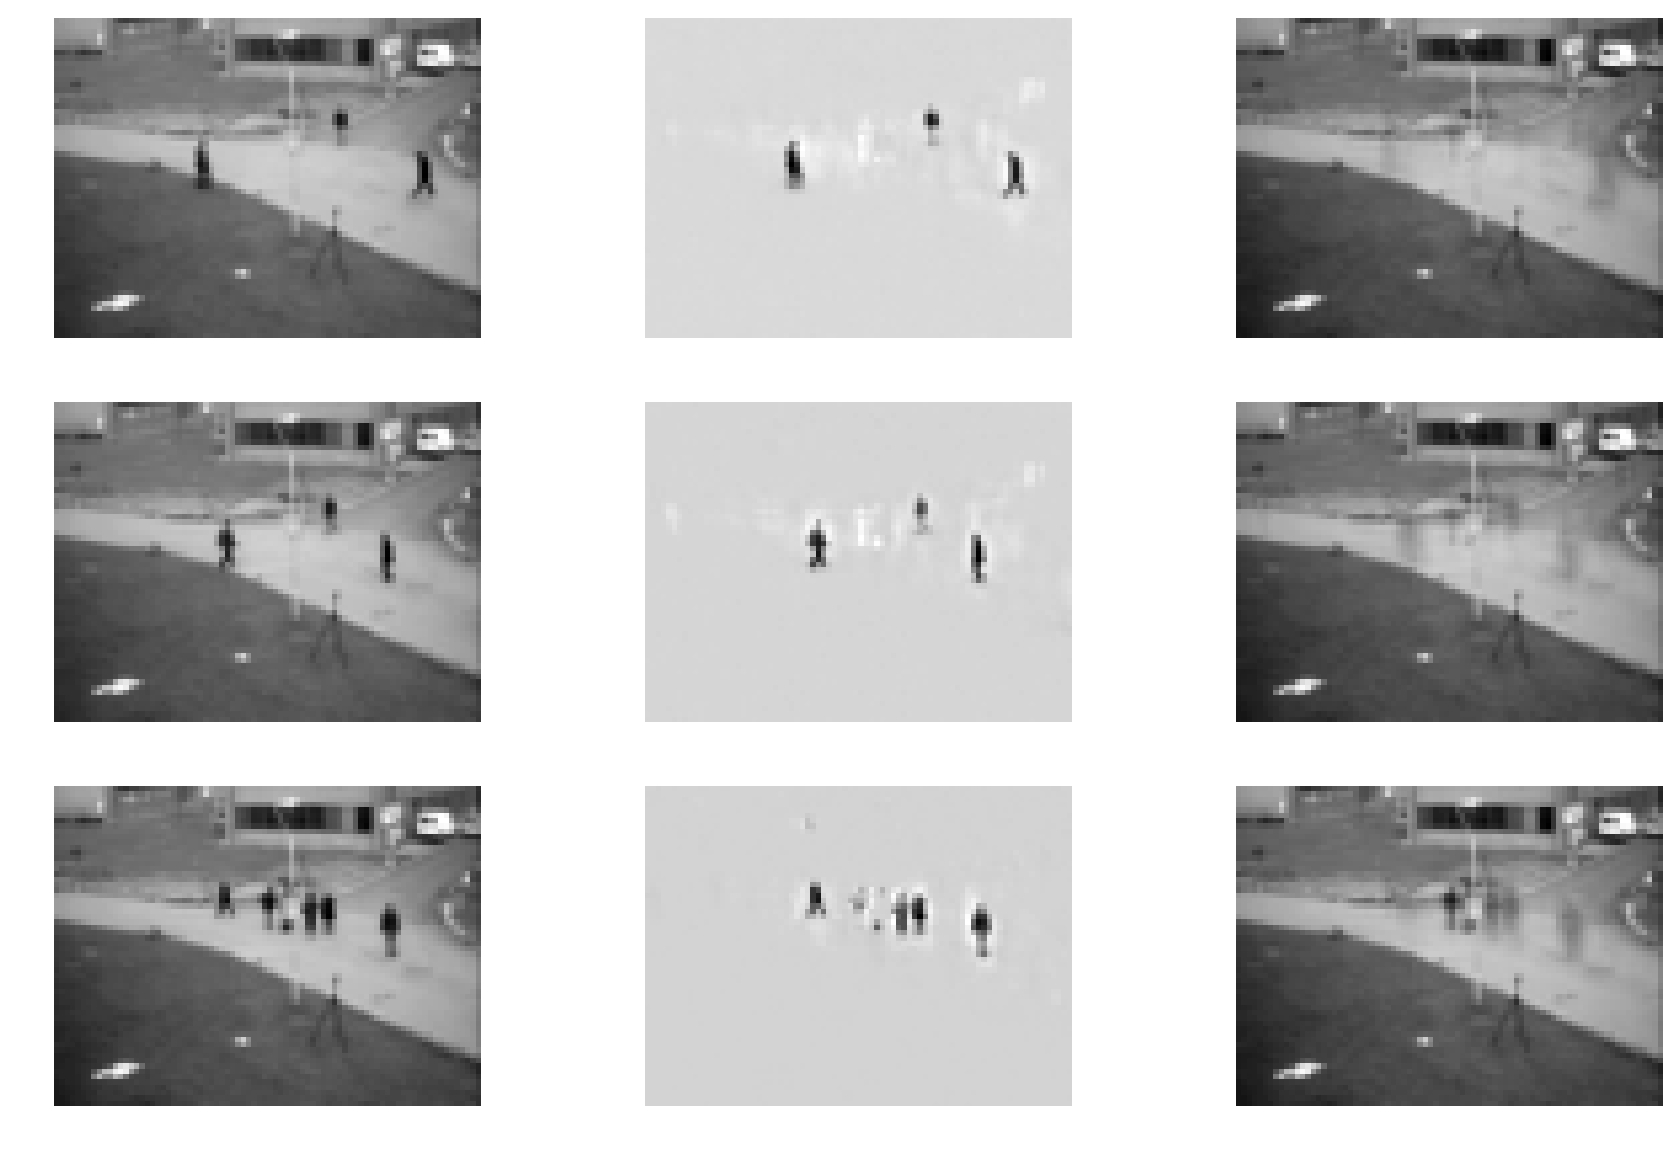

In [41]:
f = plt_images(M, S, L, [0, 100, 1000], dims)

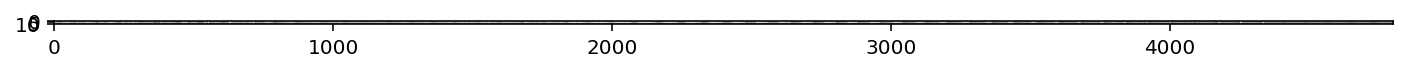

In [42]:
plt.figure(figsize=(12, 12))
plt.imshow(examples, cmap='gray')

[MoviePy] >>>> Building video people1.mp4
[MoviePy] Writing video people1.mp4


100%|█████████▉| 4900/4901 [06:26<00:00, 13.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: people1.mp4 



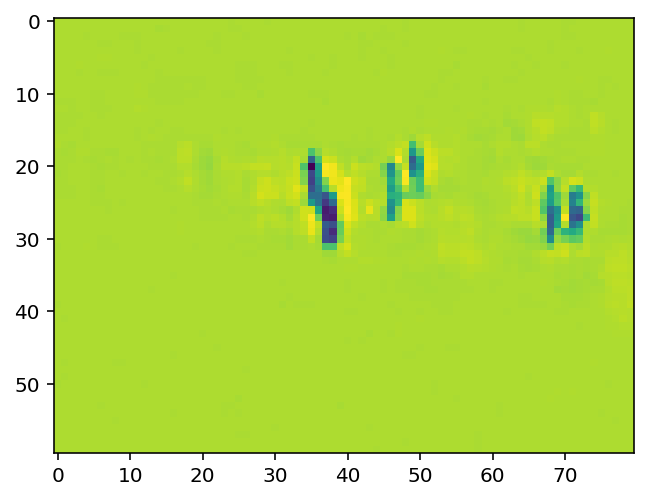

In [43]:
people_frames = S.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('people1.mp4', fps=fps)

In [44]:
AA1 = mpy.VideoFileClip('people1.mp4')
AA1.ipython_display(width=300)

100%|█████████▉| 4900/4901 [00:08<00:00, 590.41it/s]


## Alternatives to scipy.misc.imresize()

In [ ]:
import numpy as np
from PIL import Image

# open the image
image = Image.open(r"C:\Users\Admin\Pictures\kangaroo.jpg")
# get the size of the image
size = np.array(image.size)
# resize the image to half of it's original size
new_size = tuple((size*0.5).astype(int))
# new resized image
resized_image = im.resize(new_size,Image.BICUBIC)

print("Size of original image: {}".format(image.size))
print("Size of new resized image: {}".format(resized_image.size))

In [ ]:
import numpy as np
import skimage

# read the imge
image = skimage.io.imread(r"C:\Users\Admin\Pictures\kangaroo.jpg")
# get the size of the image
size = np.array(image.shape)
# resize the image to half of it's original size
new_size = (size[:2]*0.5).astype(int)
# new rsized iamge
resized_image = skimage.transform.resize(image, new_size)

print("Size of original image: {}".format(image.shape))
print("Size of new resized image: {}".format(resized_image.shape))

In [ ]:
#  Resize Image – cv2.resize()
import cv2
 
src = cv2.imread('C:\Users\Dell\Desktop\IIMB\media\sample7.jpg', cv2.IMREAD_UNCHANGED)

#percent by which the image is resized
scale_percent = 50

#calculate the 50 percent of original dimensions
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
output = cv2.resize(src, dsize)

cv2.imwrite('D:/cv2-resize-image-50.png',output) 

In [ ]:
# cv2 Resize Image Horizontally
import cv2
 
src = cv2.imread('D:/cv2-resize-image-original.png', cv2.IMREAD_UNCHANGED)

# set a new width in pixels
new_width = 300

# dsize
dsize = (new_width, src.shape[0])

# resize image
output = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)

cv2.imwrite('D:/cv2-resize-image-width.png',output) 

In [ ]:
# cv2 Resize Image Vertically

import cv2
 
src = cv2.imread('D:/cv2-resize-image-original.png', cv2.IMREAD_UNCHANGED)

# set a new height in pixels
new_height = 200

# dsize
dsize = (src.shape[1], new_height)

# resize image
output = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)

cv2.imwrite('D:/cv2-resize-image-height.png',output) 

In [5]:
import cv2
 
src = cv2.imread('sample7.jpg', cv2.IMREAD_UNCHANGED)

#percent by which the image is resized
scale_percent = 20

#calculate the 50 percent of original dimensions
width = int(src.shape[1] * scale_percent / 100)
height = int(src.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

# resize image
output = cv2.resize(src, dsize)
window_name = 'image'
cv2.imshow(window_name, output)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
#percent by which the image is resized
scale_percent = 25

#calculate the 50 percent of original dimensions
width = int(video.size[1] * scale_percent / 100)
height = int(video.size[0] * scale_percent / 100)

# dsize
dsize = (width, height)
print(dsize)

In [ ]:
from skimage.transform import resize
from PIL import Image
k=7
frames = []
for i in range(k*int(video.duration)):
    frame = video.get_frame(i/float(k))
    frame=cv2.resize(frame, dsize)
    frame = rgb2grey(frame).astype(int)
    print(frame.size)
    # frame = scipy.misc.imresize(frame, scale).flatten()
#     new_size = tuple((frame.size*0.5).astype(int))
#     frame=frame.resize(new_size,Image.BICUBIC)
    frame=frame.flatten()
    #frame = resize(frame, 25)
    frames.append(frame)
print(np.vstack(frames).T)

In [ ]:
arow = len(frames)
acol = len(frames[0])
print("Rows : " + str(arow))
print("Columns : " + str(acol))

In [ ]:
def create_data_matrix_from_video(clip, k, dims):
    frames = []
    for i in range(k * int(clip.duration)):
        frame = clip.get_frame(i / float(k))
        frame=cv2.resize(frame, dims)
        frame = rgb2grey(frame).astype(int)
        frame=frame.flatten()
        frames.append(frame)
    return np.vstack(frames).T # stack images horizontally

In [ ]:
from PIL import Image
# change resolution of image
scale =25    # scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
original_width = video.size[1]
original_height = video.size[0]

dims = (int(original_width * scale / 100), int(original_height * scale / 100))

def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([np.array(Image.fromarray(rgb2grey(video.get_frame(i/float(k))).astype(int)).resize(size=dims)).flatten() for i in range(k * int(clip.duration))]).T
fps = 100
M = create_data_matrix_from_video(video, fps, dims)

In [ ]:
np.array(Image.fromarray(rgb2grey(video.get_frame(0/float(100))).astype(int)).resize(size=dims)).flatten()